SIFT, AKAZE, & BRISK

1. Import & Dataset

In [121]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
from PIL import Image
import random

In [122]:
DATA_DIR = "D:/Berkas/Code/Semester 7/temu_kembali_citra/archive (5)/Corel-1K/Corel-1K"
OUTPUT_DIR = "output_csv"
FEATURE_DIR = "features"

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(FEATURE_DIR, exist_ok=True)

2. Membabca Dataset & Split dataset menjadi Query (10%) dan Gallery (90%)

In [123]:
data = []
for class_name in sorted(os.listdir(DATA_DIR)):
    class_path = os.path.join(DATA_DIR, class_name)
    if os.path.isdir(class_path):
        for fname in os.listdir(class_path):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                data.append({
                    "path": os.path.join(class_path, fname),
                    "label": class_name
                })

query_data, gallery_data = [], []
for class_name in sorted(os.listdir(DATA_DIR)):
    class_images = [d for d in data if d["label"] == class_name]
    if class_images:
        train, test = train_test_split(class_images, test_size=0.1, random_state=42)
        gallery_data.extend(train)
        query_data.extend(test)

print(f"✅ Query: {len(query_data)}, Gallery: {len(gallery_data)}")

pd.DataFrame(query_data).to_csv(os.path.join(OUTPUT_DIR, "query.csv"), index=False)
pd.DataFrame(gallery_data).to_csv(os.path.join(OUTPUT_DIR, "gallery.csv"), index=False)


✅ Query: 100, Gallery: 900


3. Preprocessing

In [124]:
IMG_SIZE = (256, 256)

def preprocess_image(img_path):
    try:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Gagal membaca gambar: {img_path}")
        img = cv2.resize(img, IMG_SIZE)
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
        return img.astype(np.uint8)
    except Exception as e:
        print(f"Error preprocessing {img_path}: {e}")
        return np.zeros(IMG_SIZE, dtype=np.uint8)


4. Feature Extraction Functions (SIFT, AKAZE, BRISK)

In [125]:
def extract_sift_features(img):
    sift = cv2.SIFT_create()
    _, desc = sift.detectAndCompute(img, None)
    return np.mean(desc, axis=0) if desc is not None else np.zeros(128)

def extract_akaze_features(img):
    akaze = cv2.AKAZE_create()
    _, desc = akaze.detectAndCompute(img, None)
    return np.mean(desc, axis=0) if desc is not None else np.zeros(61)

def extract_brisk_features(img):
    brisk = cv2.BRISK_create()
    _, desc = brisk.detectAndCompute(img, None)
    return np.mean(desc, axis=0) if desc is not None else np.zeros(64)


5. Pipeline Ekstraksi Fitur

In [126]:
def extract_features(csv_path, output_name, method="sift"):
    df = pd.read_csv(csv_path)
    features, labels, paths = [], [], []

    print(f"Ekstraksi fitur {method.upper()} untuk {len(df)} gambar ...")
    for _, row in tqdm(df.iterrows(), total=len(df)):
        img = preprocess_image(row["path"])

        if method == "sift":
            vec = extract_sift_features(img)
        elif method == "akaze":
            vec = extract_akaze_features(img)
        elif method == "brisk":
            vec = extract_brisk_features(img)
        else:
            raise ValueError(f"Unknown method: {method}")

        features.append(vec)
        labels.append(row["label"])
        paths.append(row["path"])

    df_out = pd.DataFrame(features)
    df_out["label"] = labels
    df_out["path"] = paths
    output_path = os.path.join(FEATURE_DIR, output_name)
    df_out.to_csv(output_path, index=False)
    print(f"Fitur {method.upper()} disimpan ke {output_path}")


6. Ekstraksi

In [127]:
for method in ["sift", "akaze", "brisk"]:
    extract_features(os.path.join(OUTPUT_DIR, "query.csv"), f"query_{method}.csv", method)
    extract_features(os.path.join(OUTPUT_DIR, "gallery.csv"), f"gallery_{method}.csv", method)

Ekstraksi fitur SIFT untuk 100 gambar ...


100%|██████████| 100/100 [00:01<00:00, 89.74it/s]


Fitur SIFT disimpan ke features\query_sift.csv
Ekstraksi fitur SIFT untuk 900 gambar ...


100%|██████████| 900/900 [00:09<00:00, 94.59it/s] 


Fitur SIFT disimpan ke features\gallery_sift.csv
Ekstraksi fitur AKAZE untuk 100 gambar ...


100%|██████████| 100/100 [00:00<00:00, 152.23it/s]


Fitur AKAZE disimpan ke features\query_akaze.csv
Ekstraksi fitur AKAZE untuk 900 gambar ...


100%|██████████| 900/900 [00:06<00:00, 146.58it/s]


Fitur AKAZE disimpan ke features\gallery_akaze.csv
Ekstraksi fitur BRISK untuk 100 gambar ...


100%|██████████| 100/100 [00:04<00:00, 20.53it/s]


Fitur BRISK disimpan ke features\query_brisk.csv
Ekstraksi fitur BRISK untuk 900 gambar ...


100%|██████████| 900/900 [00:42<00:00, 21.07it/s]


Fitur BRISK disimpan ke features\gallery_brisk.csv


7. Load Fitur & Evaluasi

In [128]:
def load_features(method):
    q = pd.read_csv(os.path.join(FEATURE_DIR, f"query_{method}.csv"))
    g = pd.read_csv(os.path.join(FEATURE_DIR, f"gallery_{method}.csv"))
    feat_cols = [c for c in q.columns if c not in ["label", "path"]]
    return q[feat_cols].values, g[feat_cols].values, q["label"].values, g["label"].values, q["path"].values, g["path"].values


def evaluate_retrieval(sim_matrix, q_labels, g_labels, top_k_values=[1, 5, 10]):
    results = {}
    for k in top_k_values:
        correct = sum(q_labels[i] in g_labels[np.argsort(sim_matrix[i])[::-1][:k]] for i in range(len(q_labels)))
        results[f"Top-{k} Accuracy"] = correct / len(q_labels)
    return results


def compute_average_precision(sim_row, query_label, gallery_labels):
    sorted_idx = np.argsort(sim_row)[::-1]
    sorted_labels = np.array(gallery_labels)[sorted_idx]
    relevant = (sorted_labels == query_label).astype(int)
    cum_relevant = np.cumsum(relevant)
    precision = cum_relevant / (np.arange(len(relevant)) + 1)
    ap = np.sum(precision * relevant) / max(np.sum(relevant), 1)
    return ap


def evaluate_map(sim_matrix, q_labels, g_labels):
    aps = [compute_average_precision(sim_matrix[i], q_labels[i], g_labels) for i in range(len(q_labels))]
    return np.mean(aps)


8. Evaluasi Top-K + mAP

In [129]:
methods = ["sift", "akaze", "brisk"]
top_k_values = [1, 5, 10, 20, 30]

topk_results = []

for method in methods:
    Xq, Xg, yq, yg, qp, gp = load_features(method)
    sim = cosine_similarity(Xq, Xg)
    accs = evaluate_retrieval(sim, yq, yg, top_k_values=top_k_values)
    mAP = evaluate_map(sim, yq, yg)
    topk_results.append({"Method": method.upper(), **accs})

df_topk = pd.DataFrame(topk_results)
display(df_topk)


Method  Top-1 Accuracy  Top-5 Accuracy  Top-10 Accuracy  Top-20 Accuracy  \
0   SIFT            0.52            0.81             0.93             0.97   
1  AKAZE            0.34            0.69             0.78             0.92   
2  BRISK            0.37            0.73             0.81             0.92   

   Top-30 Accuracy  
0             0.97  
1             0.98  
2             0.96

9. Evaluasi Precision, Recall, F1

In [130]:
metrics_results = []

for method in methods:
    Xq, Xg, yq, yg, qp, gp = load_features(method)
    sim = cosine_similarity(Xq, Xg)
    
    prf = evaluate_precision_recall_f1(sim, yq, yg, top_k=5)
    acc_eval = evaluate_retrieval(sim, yq, yg, top_k_values=[1])
    mAP = evaluate_map(sim, yq, yg)

    metrics_results.append({
        "Method": method.upper(),
        **prf,
        "mAP": mAP
    })

df_metrics = pd.DataFrame(metrics_results)
display(df_metrics)


Method  Precision  Recall  F1-score  Accuracy       mAP
0   SIFT      0.510     1.0  0.675497     0.510  0.326405
1  AKAZE      0.336     1.0  0.502994     0.336  0.257885
2  BRISK      0.368     1.0  0.538012     0.368  0.245640

10. Visualisasi Hasil Retrieval

In [131]:
def show_retrieval_results(similarity_matrix, query_paths, gallery_paths, query_labels, gallery_labels, query_index=0, top_k=5):
    sims = similarity_matrix[query_index]
    top_k_idx = np.argsort(sims)[::-1][:top_k]
    
    plt.figure(figsize=(15, 4))
    query_img = Image.open(query_paths[query_index])
    plt.subplot(1, top_k + 1, 1)
    plt.imshow(query_img)
    plt.title(f"Query\n{query_labels[query_index]}")
    plt.axis("off")

    for i, idx in enumerate(top_k_idx):
        img = Image.open(gallery_paths[idx])
        plt.subplot(1, top_k + 1, i + 2)
        plt.imshow(img)
        plt.title(f"Top-{i+1}\n{gallery_labels[idx]}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()



🔹 Query ke-7 (SIFT) — Label: africans


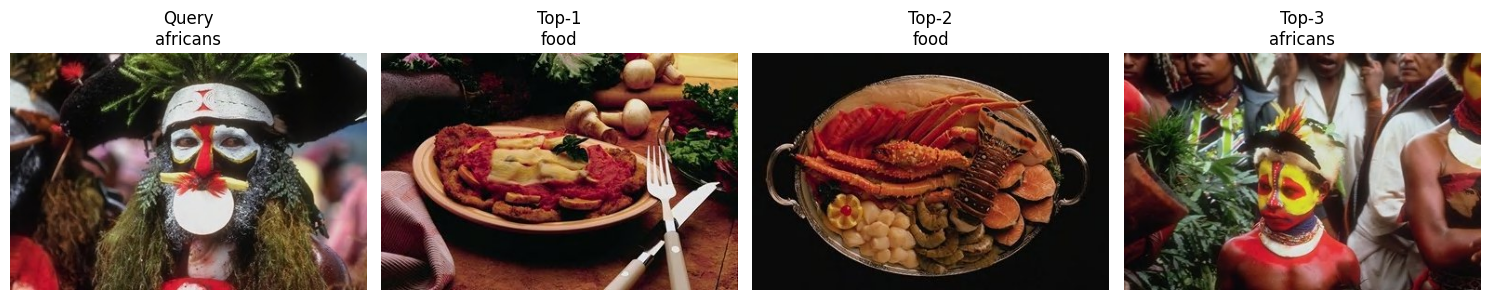


🔹 Query ke-26 (SIFT) — Label: buildings


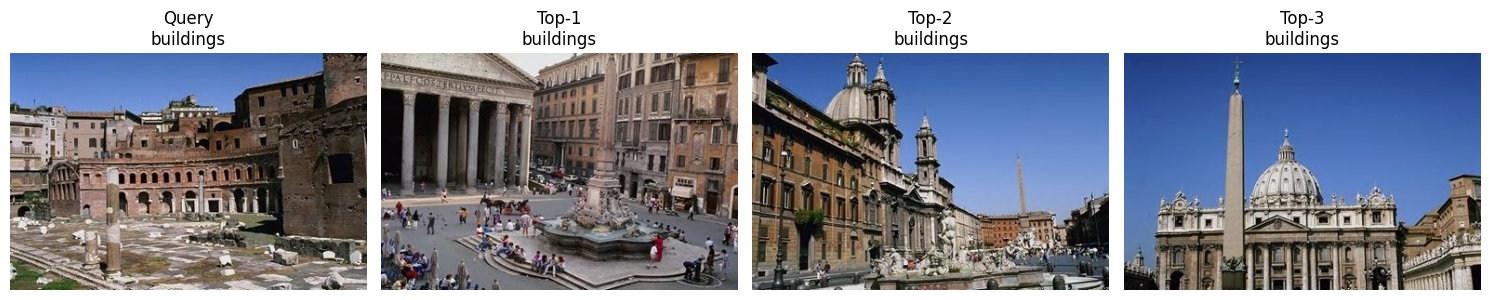


🔹 Query ke-24 (SIFT) — Label: buildings


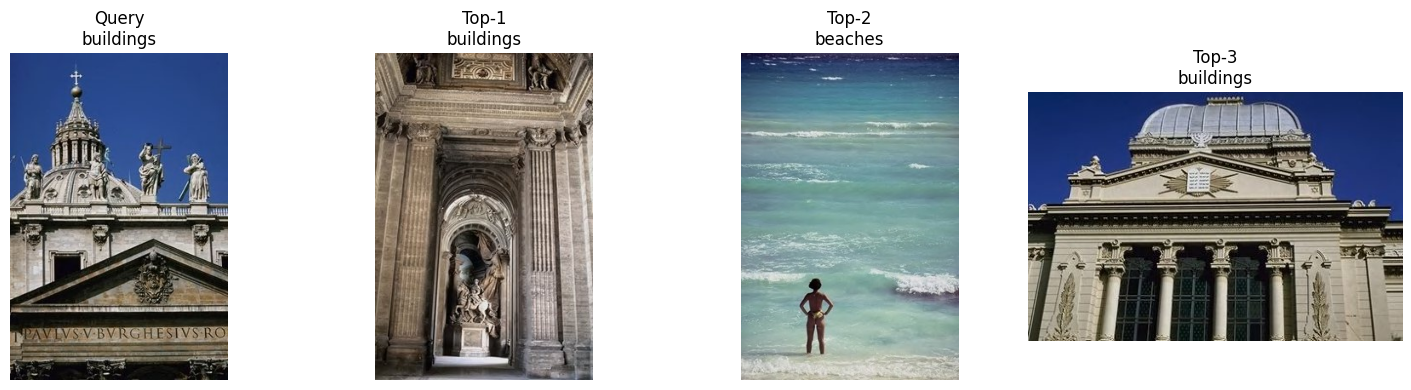

In [138]:
method_to_show = "sift"

Xq, Xg, yq, yg, pq, pg = load_features(method_to_show)
sim = cosine_similarity(Xq, Xg)

for idx in random.sample(range(len(pq)), 3):
    print(f"\n🔹 Query ke-{idx} ({method_to_show.upper()}) — Label: {yq[idx]}")
    show_retrieval_results(sim, pq, pg, yq, yg, query_index=idx, top_k=3)



🔹 Query ke-13 (AKAZE) — Label: beaches


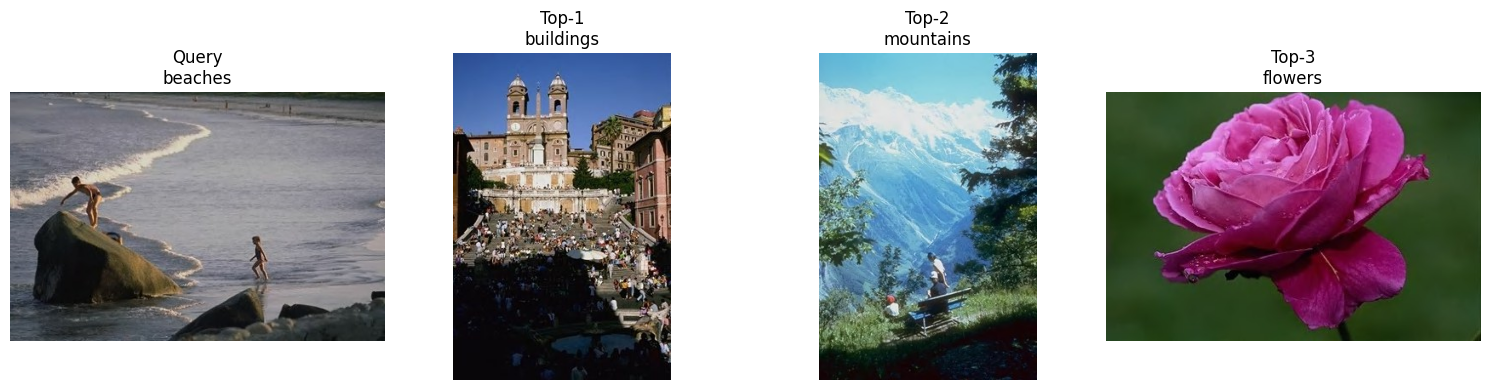


🔹 Query ke-47 (AKAZE) — Label: dinosaurs


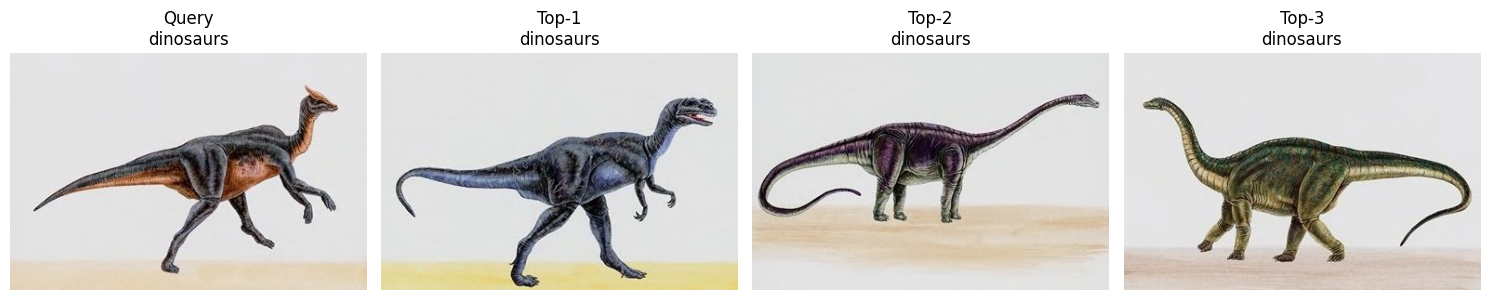


🔹 Query ke-33 (AKAZE) — Label: buses


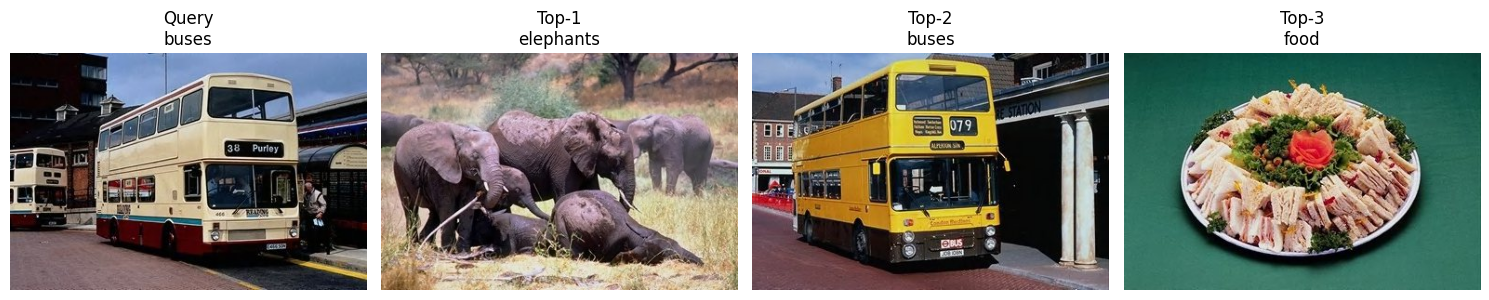

In [141]:
method_to_show = "akaze"

Xq, Xg, yq, yg, pq, pg = load_features(method_to_show)
sim = cosine_similarity(Xq, Xg)

for idx in random.sample(range(len(pq)), 3):
    print(f"\n🔹 Query ke-{idx} ({method_to_show.upper()}) — Label: {yq[idx]}")
    show_retrieval_results(sim, pq, pg, yq, yg, query_index=idx, top_k=3)


🔹 Query ke-14 (BRISK) — Label: beaches


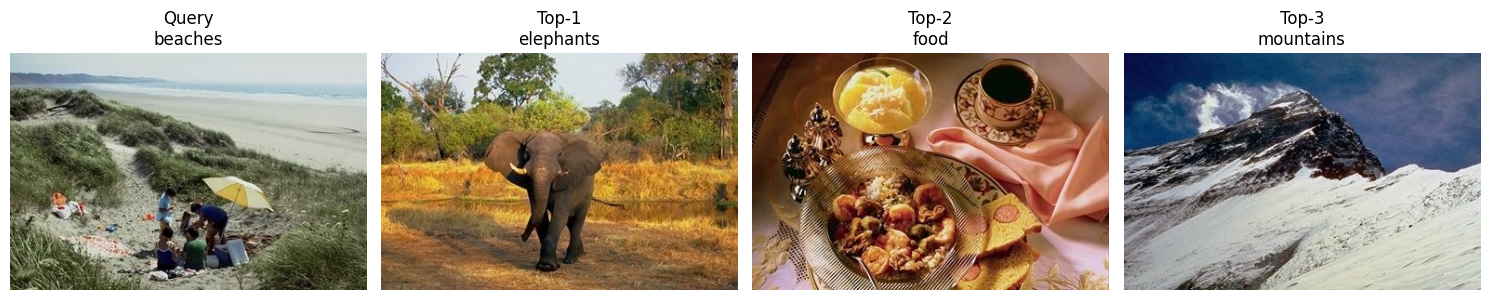


🔹 Query ke-38 (BRISK) — Label: buses


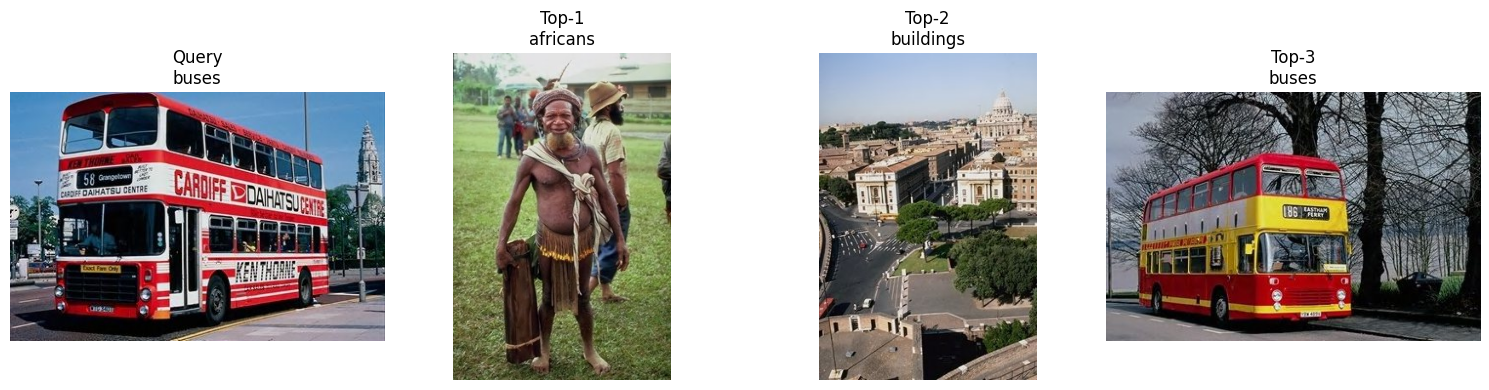


🔹 Query ke-18 (BRISK) — Label: beaches


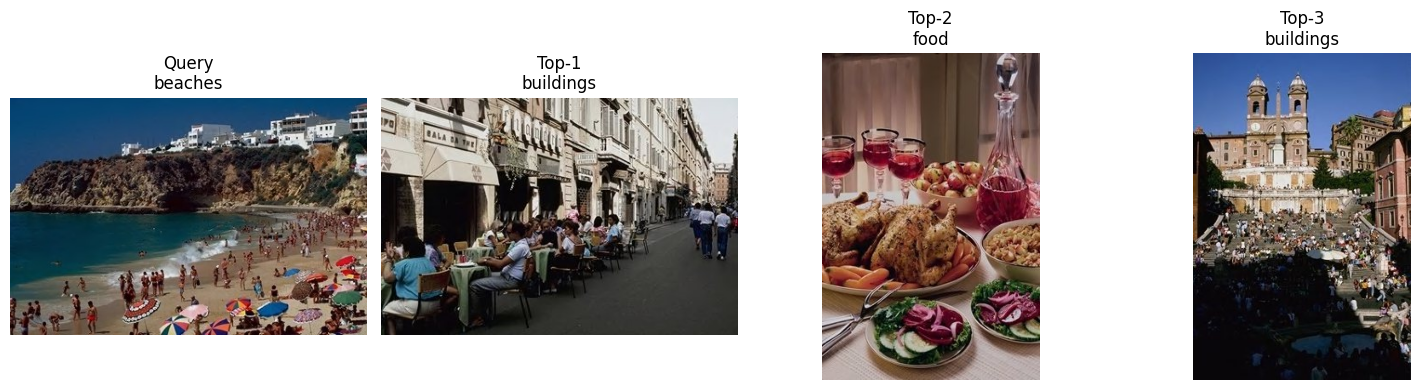

In [142]:
method_to_show = "brisk"

Xq, Xg, yq, yg, pq, pg = load_features(method_to_show)
sim = cosine_similarity(Xq, Xg)

for idx in random.sample(range(len(pq)), 3):
    print(f"\n🔹 Query ke-{idx} ({method_to_show.upper()}) — Label: {yq[idx]}")
    show_retrieval_results(sim, pq, pg, yq, yg, query_index=idx, top_k=3)